# Detection of Twitter users who use hateful lexicon using graph machine learning with Stellargraph

We consider the use-case of identifying hateful users on Twitter motivated by the work in [1] and using the dataset also published in [1]. Classification is based on a graph based on users' retweets and attributes as related to their account activity, and the content of tweets.

We pose identifying hateful users as a binary classification problem. We demonstrate the advantage of connected vs unconnected data in a semi-supervised setting with few training examples.

For connected data, we use Graph Neural Network methods, GCN [2], GAT [3], and GraphSAGE [4] as implemented in the `stellargraph` library. We pose the problem of identifying hateful tweeter users as node attribute inference in graphs.

**References**

1. "Like Sheep Among Wolves": Characterizing Hateful Users on Twitter. M. H. Ribeiro, P. H. Calais, Y. A. Santos, V. A. F. Almeida, and W. Meira Jr.  arXiv preprint arXiv:1801.00317 (2017).


2. Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 


3. Graph Attention Networks. P. Velickovic et al. ICLR 2018


4. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017.

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT, APPNP
from stellargraph import globalvar

from tensorflow.keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m, fontsize=18)
        plt.ylabel(m, fontsize=18)
        plt.xlabel('epoch', fontsize=18)
        plt.legend(['train', 'validation'], loc='best')
        plt.show()


### Loading the data

**Downloading the dataset:**

The dataset for this demo was published in [1] and it is freely available to download from Kaggle [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter/home).

The following is the description of the datasets:

>This dataset contains a network of 100k users, out of which ~5k were annotated as hateful or
>not. For each user, several content-related, network-related and activity related features
>were provided. 

Additional files of hateful lexicon can be found [here]( 
https://github.com/manoelhortaribeiro/HatefulUsersTwitter/tree/master/data/extra)

Download the dataset and then set the `data_dir` variable to point to the download location.

In [4]:
data_dir = os.path.expanduser("~/data/hateful-twitter-users")

### First load and prepare the node features

Each node in the graph is associated with a large number of features (also referred to as attributes). 

The list of features is given [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter). We repeated here for convenience.

hate :("hateful"|"normal"|"other")
  if user was annotated as hateful, normal, or not annotated.
  
  (is_50|is_50_2) :bool
  whether user was deleted up to 12/12/17 or 14/01/18. 
  
  (is_63|is_63_2) :bool
  whether user was suspended up to 12/12/17 or 14/01/18. 
        
  (hate|normal)_neigh :bool
  is the user on the neighborhood of a (hateful|normal) user? 
  
  [c_] (statuses|follower|followees|favorites)_count :int
  number of (tweets|follower|followees|favorites) a user has.
  
  [c_] listed_count:int
  number of lists a user is in.

  [c_] (betweenness|eigenvector|in_degree|outdegree) :float
  centrality measurements for each user in the retweet graph.
  
  [c_] *_empath :float
  occurrences of empath categories in the users latest 200 tweets.

  [c_] *_glove :float          
  glove vector calculated for users latest 200 tweets.
  
  [c_] (sentiment|subjectivity) :float
  average sentiment and subjectivity of users tweets.
  
  [c_] (time_diff|time_diff_median) :float
  average and median time difference between tweets.
  
  [c_] (tweet|retweet|quote) number :float
  percentage of direct tweets, retweets and quotes of an user.
  
  [c_] (number urls|number hashtags|baddies|mentions) :float
  number of bad words|mentions|urls|hashtags per tweet in average.
  
  [c_] status length :float
  average status length.
  
  hashtags :string
  all hashtags employed by the user separated by spaces.
  
**Notice** that c_ are attributes calculated for the 1-neighborhood of a user in the retweet network (averaged out).

First, we are going to load the user features and prepare them for machine learning.

In [5]:
users_feat = pd.read_csv(os.path.join(data_dir, 
                                      'users_neighborhood_anon.csv'))
users_feat.head()

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698


Let's have a look at the distribution of hateful, normal (not hateful), and other (unknown) users in the dataset

In [6]:
print("Initial hateful/normal users distribution")
print(users_feat.shape)
print(users_feat.hate.value_counts())

Initial hateful/normal users distribution
(100386, 1039)
other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


There is a clear imbalance on the number of users tagged as hateful vs normal and unknown.

### Data cleaning and preprocessing

The dataset as given includes a large number of graph related features that are manually extracted. 

Since we are going to employ modern graph neural networks methods for classification, we are going to drop these manually engineered features. 

The power of Graph Neural Networks stems from their ability to learn useful graph-related features eliminating the need for manual feature engineering.

In [7]:
def data_cleaning(feat):
    feat = feat.drop(columns=["hate_neigh", "normal_neigh"])
    
    # Convert target values in hate column from strings to integers (0,1,2)
    feat['hate'] = np.where(feat['hate']=='hateful', 1, np.where(feat['hate']=='normal', 0, 2))
    
    # missing information
    number_of_missing = feat.isnull().sum()
    number_of_missing[number_of_missing!=0]
    
    # Replace NA with 0
    feat.fillna(0, inplace=True)

    # droping info about suspension and deletion as it is should not be use din the predictive model
    feat.drop(feat.columns[feat.columns.str.contains("is_")], axis=1, inplace=True)

    # drop glove features
    feat.drop(feat.columns[feat.columns.str.contains("_glove")], axis=1, inplace=True)

    # drop c_ features
    feat.drop(feat.columns[feat.columns.str.contains("c_")], axis=1, inplace=True)

    # drop sentiment features for now
    feat.drop(feat.columns[feat.columns.str.contains("sentiment")], axis=1, inplace=True)

    # drop hashtag feature
    feat.drop(['hashtags'], axis=1, inplace=True)

    # Drop centrality based measures
    feat.drop(columns=['betweenness', 'eigenvector', 'in_degree', 'out_degree'], inplace=True)
    
    feat.drop(columns=['created_at'], inplace=True)
    
    return feat

In [8]:
node_data = data_cleaning(users_feat)

Of the original **1037** node features, we are keeping only **204** that are based on a user's attributes and tweet lexicon. We have removed any manually engineered graph features since the graph neural network algorithms we are going to use will automatically determine the best features to use during training.

In [9]:
node_data.shape

(100386, 206)

In [10]:
node_data.head()

,user_id,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,0,101767,3504,3673,81635,53,0.000513,0.002564,0.002564,...,16.0,121.0,79.0,5.0,75.565000,82.0,18.0,159.0,356.020101,74.0
1,1,2,2352,19609,309,61,197,0.003180,0.000867,0.003469,...,40.0,199.0,0.0,0.0,101.713568,20.0,10.0,6.0,17519.116162,45.0
2,2,2,1044,2371,2246,561,16,0.005272,0.000000,0.005272,...,328.0,113.0,87.0,0.0,128.130000,219.0,16.0,158.0,46417.758794,2010.0
3,3,2,167172,3004,298,3242,53,0.004016,0.005801,0.001339,...,127.0,69.0,131.0,3.0,85.760000,149.0,10.0,26.0,656.889447,72.0
4,4,2,1998,17643,19355,485,239,0.001134,0.000000,0.000756,...,1710.0,101.0,99.0,0.0,152.175000,198.0,35.0,7.0,55991.356784,48197.0


The continous features in our dataset have distributions with very long tails. We apply normalization to correct for this.

In [11]:
# Ignore the first two columns because those are user_id and hate (the target variable)
df_values = node_data.iloc[:, 2:].values

In [12]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True) 

In [13]:
df_values_log = pt.fit_transform(df_values)

Let's have a look at one of the normalized features before and after the power transform was applied.

The feature we are going to look at is a user's number of followers.

In [14]:
sns_rc = {'lines.linewidth': 3, 'figure.figsize':(12,6)}
sns.set_context("paper", rc = sns_rc) 
sns.set_style("whitegrid", {'axes.grid' : False})

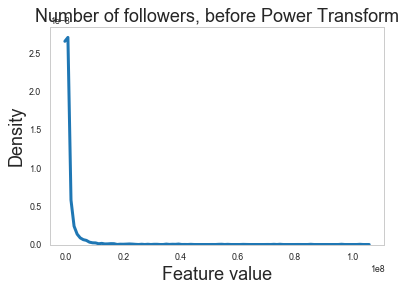

In [15]:
sns.kdeplot(df_values[:, 1])
s = plt.ylabel("Density", fontsize=18)
s = plt.xlabel("Feature value", fontsize=18)
s = plt.title("Number of followers, before Power Transform", fontsize=18)

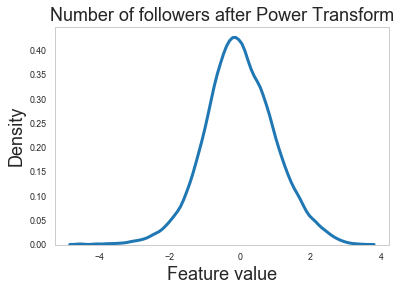

In [16]:
sns.kdeplot(df_values_log[:, 1])
s = plt.ylabel("Density", fontsize=18)
s = plt.xlabel("Feature value", fontsize=18)
s = plt.title("Number of followers after Power Transform", fontsize=18)

Feature normalization looks like it is doing the right thing as the raw features have long tails that are eliminated after applying the power transform. 

So let us use the normalized features from now on.

In [17]:
node_data.iloc[:, 2:] = df_values_log

In [18]:
# Set the dataframe index to be the same as the user_id and drop the user_id columns
node_data.index = node_data.index.map(str)
node_data.drop(columns=['user_id'], inplace=True)

Node features are now ready for machine learning.

In [19]:
node_data.head()

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,1.541150,0.046773,1.104767,1.869391,0.017835,-1.752256,0.164900,0.181173,0.875069,...,-0.632488,-0.049013,0.321929,-0.369992,-1.036127,-0.796091,0.047430,0.356495,-1.888186,-1.299249
1,2,-0.700240,0.772450,-0.526061,-1.434183,0.613187,-0.735320,-0.864337,0.599279,1.610977,...,-0.071721,1.479066,-1.999580,-1.545285,-0.188945,-1.875745,-0.626192,-1.972207,0.160925,-1.512603
2,2,-1.077284,-0.127775,0.767345,-0.669050,-0.523882,-0.118440,-1.573040,1.211083,-0.154213,...,1.618609,-0.201320,0.452537,-1.545285,0.637869,0.884530,-0.096918,0.348954,0.698841,0.122176
3,2,1.908494,-0.021575,-0.548705,0.078540,0.017835,-0.472125,1.281633,-0.544862,1.259492,...,0.781915,-1.018822,1.085858,-0.662393,-0.701835,0.088472,-0.626192,-1.254997,-1.576801,-1.311031
4,2,-0.778589,0.729918,2.296049,-0.725089,0.700128,-1.488804,-1.573040,-0.969812,0.199834,...,3.422701,-0.427866,0.638106,-1.545285,1.370832,0.655433,0.955922,-1.914894,0.803553,1.472247


### Next load the graph

Now that we have the node features prepared for machine learning, let us load the retweet graph.

In [20]:
g_nx = nx.read_edgelist(path=os.path.expanduser(os.path.join(data_dir,
                                                             "users.edges")))

In [21]:
g_nx.number_of_nodes(), g_nx.number_of_edges()

(100386, 2194979)

The graph has just over 100k nodes and approximately 2.2m edges.

We aim to train a graph neural network model that will predict the "hate"attribute on the nodes.

For computation convenience, we have mapped the target labels **normal**, **hateful**, and **other** to the numeric values **0**, **1**, and **2** respectively.

In [22]:
print(set(node_data["hate"]))

{0, 1, 2}


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to split our data into training and test sets.

The total number of annotated nodes is very small when compared to the total number of nodes in the graph. We are only going to use 15% of the annotated nodes for training and the remaining 85% of nodes for testing.

First, we are going to select the subset of nodes that are annotated as hateful or normal. These will be the nodes that have 'hate' values that are either 0 or 1.

In [23]:
# choose the nodes annotated with normal or hateful classes
annotated_users = node_data[node_data['hate']!=2]

In [24]:
annotated_users.head()

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,1.541150,0.046773,1.104767,1.869391,0.017835,-1.752256,0.164900,0.181173,0.875069,...,-0.632488,-0.049013,0.321929,-0.369992,-1.036127,-0.796091,0.047430,0.356495,-1.888186,-1.299249
22,0,1.610235,-0.311474,0.224841,-1.350517,-0.883454,-1.178383,-1.035463,-0.172829,-0.253731,...,-1.291040,1.239586,-1.215177,1.557857,-1.689390,-0.914795,-0.023220,-0.029203,-0.850158,-1.073416
29,0,0.676296,0.907563,-0.583110,-0.473819,1.029022,0.133058,-0.272510,0.154618,1.168792,...,-0.448834,1.060920,-0.907346,0.969577,0.747312,-0.432903,0.529664,0.791479,-0.834524,-0.737971
44,0,-0.564326,-0.167266,0.174262,-0.364344,-0.689414,0.560514,-0.332782,0.226878,1.359779,...,0.483518,-1.269935,1.264966,-0.254387,0.863865,0.543677,0.047430,0.661312,0.758658,1.137312
85,0,1.036340,-0.137409,-0.777300,1.135700,-0.145647,-0.882219,-1.107841,1.624682,0.028468,...,-0.476405,0.374573,-0.074243,0.355409,-0.302047,-0.340005,-0.524781,0.271756,-0.559000,-0.665185


In [25]:
annotated_users.shape

(4971, 205)

In [26]:
annotated_user_features = annotated_users.drop(columns=['hate'])
annotated_user_targets = annotated_users[['hate']]

There are 4971 annoted nodes out of a possible, approximately, 100k nodes.

In [27]:
print(annotated_user_targets.hate.value_counts())

0    4427
1     544
Name: hate, dtype: int64


In [28]:
# split the data
train_data, test_data, train_targets, test_targets = train_test_split(annotated_user_features,
                                         annotated_user_targets,
                                         test_size=0.85,
                                         random_state=101)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print("Train data number of 0s {} and 1s {}".format(np.sum(train_targets==0), 
                                                    np.sum(train_targets==1)))
print("Test data number of 0s {} and 1s {}".format(np.sum(test_targets==0), 
                                                   np.sum(test_targets==1)))

Sizes and class distributions for train/test data
Shape train_data (745, 204)
Shape test_data (4226, 204)
Train data number of 0s 664 and 1s 81
Test data number of 0s 3763 and 1s 463


In [29]:
train_targets.shape, test_targets.shape

((745, 1), (4226, 1))

In [30]:
train_data.shape, test_data.shape

((745, 204), (4226, 204))

We are going to use 745 nodes for training and 4226 nodes for testing.

In [31]:
# choosing features to assign to a graph, excluding target variable
node_features = node_data.drop(columns=['hate'])

### Dealing with imbalanced data

Because the training data exhibit high imbalance, we introduce class weights.

In [32]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                     np.unique(train_targets), 
                                     train_targets[:,0])
train_class_weights = dict(zip(np.unique(train_targets), 
                               class_weights))
train_class_weights

{0: 0.5609939759036144, 1: 4.598765432098766}

Our data is now ready for machine learning.

Node features are stored in the Pandas DataFrame `node_features`.

The graph in networkx format is stored in the variable `g_nx`.

### Specify global parameters

Here we specify some parameters that control the type of model we are going to use. For example, we specify the base model type, e.g., GCN, GraphSAGE, etc, as well as model-specific parameters.

In [251]:
model_type = 'appnp'    # Can be either gcn, gat, or graphsage

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50; 
    num_samples = [20, 10]
    epochs = 30          # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    epochs = 20          # The number of training epochs
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20         # The number of training epochs  
elif model_type == 'appnp':
    teleport_probability = 0.1
    epochs = 20

## Creating the base graph machine learning model in Keras

Now create a `StellarGraph` object from the `NetworkX` graph and the node features and targets. It is `StellarGraph` objects that we use in this library to perform machine learning tasks on.

In [250]:
G = sg.StellarGraph(g_nx, node_features=node_features)

KeyboardInterrupt: 

To feed data from the graph to the Keras model we need a generator. The generators are specialized to the model and the learning task. 

For training we map only the training nodes returned from our splitter and the target values.

In [252]:
if model_type == 'graphsage':
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)
elif (model_type == 'gcn') or (model_type == 'appnp'): 
    generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets, )
elif model_type == 'gat':
    generator = FullBatchNodeGenerator(G, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets,)

KeyboardInterrupt: 

Next we create the GNN model. We need to specify model-specific parameters based on whether we want to use GCN, GAT, or GraphSAGE.

In [292]:
if model_type == 'graphsage':
    base_model = GraphSAGE(
        layer_sizes=[32, 32],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == 'gcn':
    base_model = GCN(
        layer_sizes=[32, 16],
        generator = generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "elu"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == 'gat':
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.node_model()
    
elif model_type == 'appnp':
    
    appnp = APPNP(layer_sizes=[train_targets.shape[-1]], 
              activations=['relu', 'relu'], 
              bias=True,
              generator=generator, 
              teleport_probability=0.1, 
              dropout=0.5, 
              kernel_regularizer='l2'
    )
    
    in_layer = layers.Input(shape=(len(train_data.columns),))
    layer = layers.Dense(32, activation='relu', kernel_regularizer="l2")(in_layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.Dense(32, activation='relu', kernel_regularizer="l2")(layer)
    layer = layers.Dropout(0.5)(layer)

    #note the dimension of the output should equal the number of classes to predict!
    layer = layers.Dense(train_targets.shape[-1], activation='sigmoid')(layer)

    mlp_model = Model(inputs=in_layer, outputs=layer)
    
    mlp_model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )

### Create a Keras model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `base_model` and outputs being the predictions from the softmax layer.

In [293]:
if model_type != 'appnp':
    model = Model(inputs=x_inp, outputs=prediction)

We compile our Keras model to use the `Adam` optimiser and the binary cross entropy loss.

In [294]:
if model_type != 'appnp':
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )
    model 

Train the model, keeping track of its loss and accuracy on the training set, and its performance on the test set during the training. We don't use the test set during training but only for measuring the trained model's generalization performance.

In [295]:
test_gen = generator.flow(test_data.index, test_targets)

KeyboardInterrupt: 

Now we can train the model by calling the `fit_generator` method.

In [296]:
class_weight = None
if model_type == 'graphsage':
    class_weight=train_class_weights

if model_type == 'appnp':
    history = mlp_model.fit(
        train_data,
        train_targets,
        epochs=10,
        validation_data=(test_data, test_targets),
        verbose=1,
        shuffle=True,
        class_weight=class_weight,
    )
    
    x_inp, x_out = appnp.propagate_model(mlp_model)
    model = Model(inputs=x_inp, outputs=x_out)
    
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )

else:
    history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=1,
        shuffle=False,
        class_weight=class_weight,
    )

Train on 745 samples, validate on 4226 samples
Epoch 1/10
745/745 [==============================] - 1s 904us/sample - loss: 1.2403 - acc: 0.7772 - val_loss: 0.9260 - val_acc: 0.8904
Epoch 2/10
745/745 [==============================] - 0s 155us/sample - loss: 0.8645 - acc: 0.8819 - val_loss: 0.7378 - val_acc: 0.8904
Epoch 3/10
745/745 [==============================] - 0s 155us/sample - loss: 0.6736 - acc: 0.8886 - val_loss: 0.5926 - val_acc: 0.8904
Epoch 4/10
745/745 [==============================] - 0s 152us/sample - loss: 0.5466 - acc: 0.8913 - val_loss: 0.5019 - val_acc: 0.8904
Epoch 5/10
745/745 [==============================] - 0s 149us/sample - loss: 0.4560 - acc: 0.8899 - val_loss: 0.4571 - val_acc: 0.8904
Epoch 6/10
745/745 [==============================] - 0s 146us/sample - loss: 0.4005 - acc: 0.8913 - val_loss: 0.4146 - val_acc: 0.8904
Epoch 7/10
745/745 [==============================] - 0s 145us/sample - loss: 0.3633 - acc: 0.8913 - val_loss: 0.3915 - val_acc: 0.8904
E

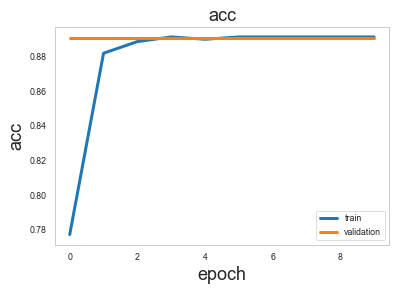

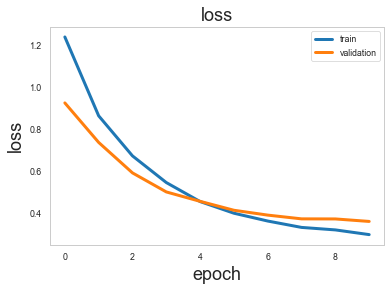

In [297]:
plot_history(history)

### Model Evaluation

Now we have trained the model, let's evaluate it on the test set.

We are going to consider 4 evaluation metrics calculated on the test set: Accuracy, Area Under the ROC curve (AU-ROC), the ROC curve, and the confusion table.

#### Accuracy

In [298]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.3650
	acc: 0.8935


#### AU-ROC

Let's use the trained GNN model to make a prediction for each node in the graph.

Then, select only the predictions for the nodes in the test set and calculate the AU-ROC as another performance metric in addition to the accuracy shown above.

In [272]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)

In [273]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [274]:
all_predictions.shape

(100386, 1)

In [275]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=node_data.index)

Let's extract the predictions for the test data only.

In [276]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [277]:
test_preds.shape

(4226, 1)

The predictions are the probability of the true class that in this case is the probability of a user being hateful.

In [278]:
test_preds.head()

,0
11717,0.292819
63824,0.097813
19161,0.016217
57412,0.065965
98222,0.106488


In [279]:
test_predictions = test_preds.values
test_predictions_class = ((test_predictions>0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.8824997747190587


#### Confusion table

In [280]:
pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,3763,0
1,458,5


#### ROC curve

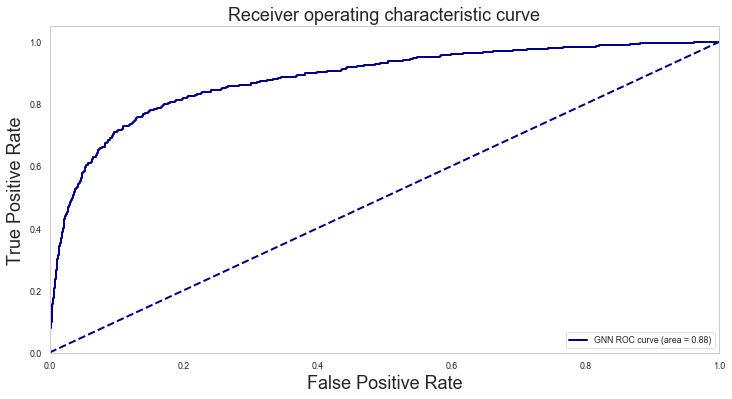

In [281]:
fpr, tpr, thresholds = metrics.roc_curve(test_df['True'], test_df['Predicted_score'], pos_label=1)
plt.figure(figsize=(12,6,))

lw = 2
plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='GNN ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Visualisation of node embeddings

Evaluate node embeddings as activations of the output of one of the graph convolutional or aggregation layers in the Keras model, and visualise them, coloring nodes by their subject label.

You can find the index of the layer of interest by calling `model.layers`.

First, create a Keras model for calculating the embeddings

In [299]:
if model_type == 'graphsage':
    # For GraphSAGE, we are going to use the output activations 
    # of the second GraphSAGE layer as the node embeddings
    # x_inp, prediction
    emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
    emb = emb_model.predict_generator(generator=all_gen, )
elif model_type == 'gcn':
    # For GCN, we are going to use the output activations of 
    # the second GCN layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == 'gat':
    # For GAT, we are going to use the output activations of the 
    # first Graph Attention layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == 'appnp':
    # the hidden layers of the model have only been trained on node features
    # will these embeddings be useful?
    mlp_emb_model = Model(inputs=in_layer, outputs=mlp_model.layers[-2].output) 

    x_in_emb, x_out_emb = appnp.propagate_model(mlp_emb_model)

    emb_model = Model(inputs=x_in_emb, outputs=x_out_emb)
    emb = emb_model.predict_generator(generator=all_gen)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_90:0


In [300]:
emb = emb.squeeze()

In [301]:
if model_type == "graphsage":
    emb_all_df = pd.DataFrame(emb, index=node_data.index)
elif model_type == "gcn" or model_type == "gat" or model_type == "appnp":
    emb_all_df = pd.DataFrame(emb, index=G.nodes())

Select the embeddings for the test set. We are only going to visualise the test set embeddings.

In [302]:
emb_test = emb_all_df.loc[test_data.index, :]

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [303]:
X = emb_test
y = test_targets

In [304]:
X.shape

(4226, 16)

In [305]:
transform = TSNE # or use PCA 

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed['label'] = y

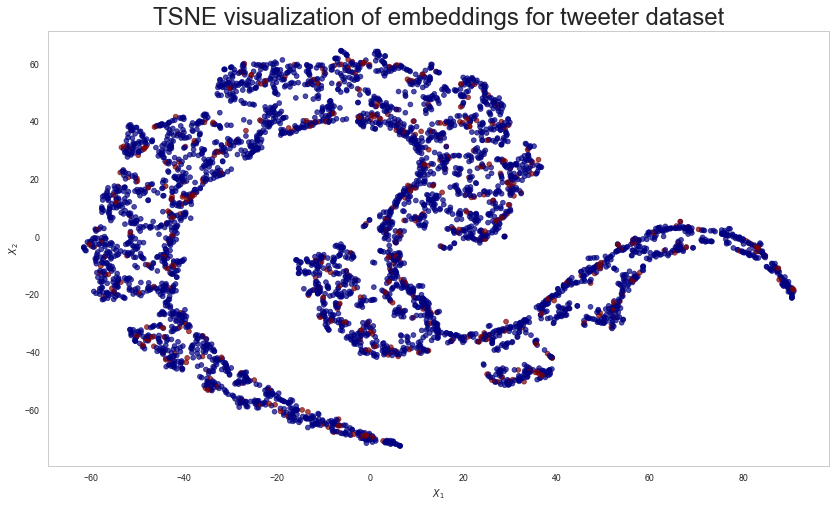

In [306]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14,8,))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of embeddings for tweeter dataset'.format(transform.__name__), fontsize=24)
plt.show()

The node embeddings shown above indicate that the majority of hateful users tend to cluster together. However, some normal users are also in the same neighbourhood and these will be difficult to distinguish from hateful ones. Similarly, there is a small number of hateful users dispersed among normal users and these will also be difficult classify correctly.

### Predictions using Logistic Regression

Finally, we train a Logistic Regression model on the same train and test data but this time ignoring the graph structure and focusing entirely on the node features.

The variables `train_data`, `test_data`, `train_targets`, and `test_targets`, hold the data we need to train the Logistic Regression classifier. 

In [100]:
lr = LogisticRegressionCV(cv=5, 
                          class_weight=class_weight, 
                          max_iter=10000)  # Let's use the default parameters

In [101]:
lr.fit(train_data, train_targets.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

We can now use the trained model to predict the test data

In [102]:
test_preds_lr = lr.predict_proba(test_data)

In [103]:
test_preds_lr.shape

(4226, 2)

#### Accuracy

In [104]:
lr.score(test_data, test_targets)

0.907950780880265

#### Calculate AU-ROC metric

In [105]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": test_targets[:,0]})
roc_auc_lr = metrics.roc_auc_score(test_df_lr['True'].values, test_df_lr['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc_lr)

The AUC on test set:

0.8581269597289513


#### The confusion table

In [106]:
pd.crosstab(test_df_lr['True'], test_df_lr['Predicted_class'])

Predicted_class,0,1
True,,
0,3652,111
1,278,185


#### The ROC curve

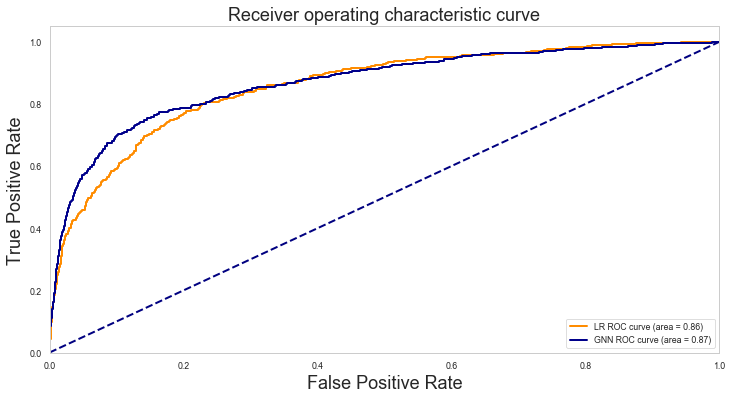

In [107]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(test_df_lr['True'], test_df_lr['Predicted_score'], pos_label=1)
plt.figure(figsize=(12,6,))
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='LR ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='GNN ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

Let's have a closer look at the True Positive Rate for the GNN and Logistic Regression models at 2% False Positive Rate.

In [283]:
print("At 2% FPR, GNN TPR={:.3f}, LR TPR={:.3f}".format(np.interp(0.02, fpr, tpr), 
                                                        np.interp(0.02, fpr_lr, tpr_lr)))

At 2% FPR, GNN TPR=0.395, LR TPR=0.346


#### Comparison between LR and GNN

**Note:** This comparison is valid when comparing GraphSAGE with Logistic Regression using a specific split of the data. Using a different GNN algorithm will very likely produce different numerical results, although, the conclusion below still generally stands.

Comparing the ROC curves between the two machine leanring methods, we see that adding the relatioship information in our machine learning model via the training of a GNN, improves overall performance.

When classifying a user as hateful, it is important to minimise the number of false positives that is the number of normal users that are incorrectly classified as hateful. At the same time, we would like to classify as many hateful users as possible. We can achieve both of these goals by setting decision thresholds guided by the ROC curve. 

If we are willing to tolerate 2% false positive rate, then the GNN model achieves a true positive rate of >10% higher than the logistic regression model. That is we can correctly identify more hateful users for the same, low number, of misclassified users. 